# Preliminary Classification Using Resampled Dataset
- Exactly the same code as the original nb06_extra2 except the order of train_test split
- train_test split first, train models on resampled train set

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC

In [4]:
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

# Preprocess Majority

In [5]:
selection10 = pd.read_csv('./data/select_train_data10.csv')

In [6]:
X = np.array(selection10.iloc[:, :-1])
y = np.array(selection10.iloc[:, -1])

In [7]:
%%time
tl = TomekLinks(n_jobs=8, ratio='majority')
X_tl, y_tl = tl.fit_sample(X, y)

print('Before tomek links: size of X: ', X.shape)
print('After  tomek links: size of X: ', X_tl.shape)
print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

Before tomek links: size of X:  (595212, 35)
After  tomek links: size of X:  (586179, 35)
Before tomek links: class0/class1 = 573518 / 21694
After  tomek links: class0/class1 = 564485 / 21694
CPU times: user 8min 51s, sys: 205 ms, total: 8min 51s
Wall time: 1min 41s


# Undersampling class0 combined with oversampling of class1 by SMOTE

### Set up targets for number of samples for each class, resample training set

In [15]:
rstate = 55
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)

num_class1 = np.sum(y_train)
num_class1_to_resample = 3 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

print('Before Resampling: size of X: ', X_tl.shape)
print('After  Resampling: size of X: ', X_tlrus.shape)

print('Before Resampling: class0/class1 =%7d/%6d' % (len(y_train)-np.sum(y_train), np.sum(y_train)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

Before Resampling: size of X:  (586179, 35)
After  Resampling: size of X:  (60844, 35)
Before Resampling: class0/class1 = 395114/ 15211
After  Resampling: class0/class1 =  45633/ 45633


### Run single round of classification with a set random_state for train_test split

======== Random Forest ========
             precision    recall  f1-score   support

          0     0.9669    0.8759    0.9191    169371
          1     0.0624    0.2159    0.0969      6483

avg / total     0.9335    0.8515    0.8888    175854

======== Gradient Boost ========
             precision    recall  f1-score   support

          0     0.9643    0.9763    0.9703    169371
          1     0.0817    0.0551    0.0658      6483

avg / total     0.9317    0.9424    0.9369    175854

CPU times: user 49.1 s, sys: 194 ms, total: 49.3 s
Wall time: 6.85 s


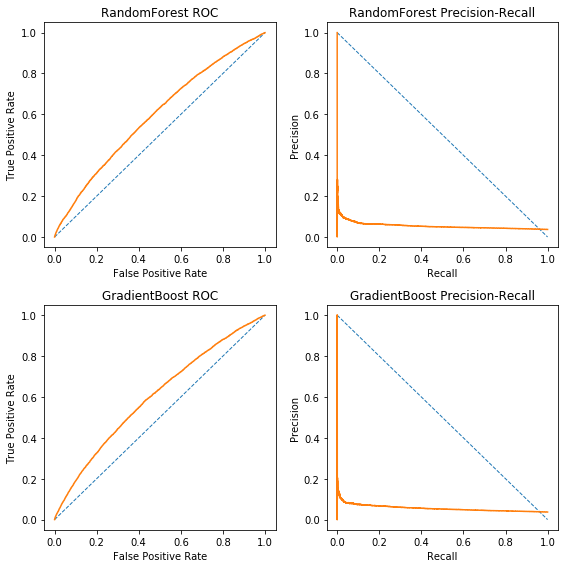

In [9]:
%%time
if True:
    
    fig = plt.figure(figsize=(8, 8))
    neutral_line = np.linspace(0, 1, 10)

    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_res, y_res)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)
    print('======== Random Forest ========')
    print(report1)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11 = fig.add_subplot(2, 2, 1)
    ax12 = fig.add_subplot(2, 2, 2)
    ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)
    print('======== Gradient Boost ========')
    print(report2)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21 = fig.add_subplot(2, 2, 3)
    ax22 = fig.add_subplot(2, 2, 4)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    plt.tight_layout()

### Run classification multiple rounds with random train_test splitting (try 10 times)

RFC Mean Gini: 0.207+/-0.000, Best=0.207
XGB Mean Gini: 0.232+/-0.000, Best=0.232
CPU times: user 38.5 s, sys: 163 ms, total: 38.7 s
Wall time: 6.75 s


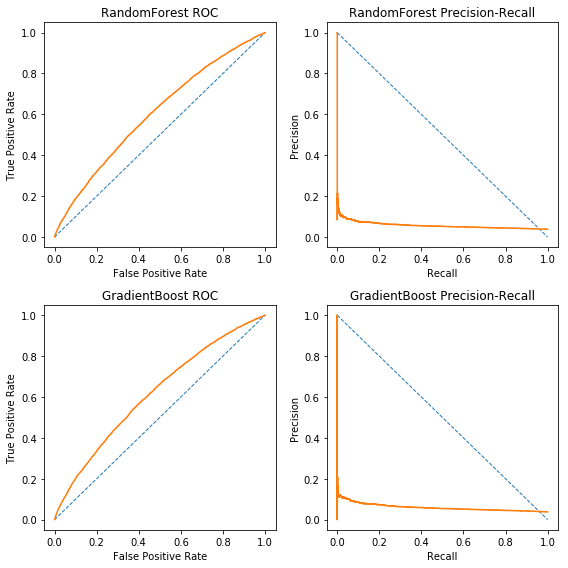

In [23]:
%%time
fig = plt.figure(figsize=(8, 8))
ax11 = fig.add_subplot(2, 2, 1)
ax12 = fig.add_subplot(2, 2, 2)
ax21 = fig.add_subplot(2, 2, 3)
ax22 = fig.add_subplot(2, 2, 4)

neutral_line = np.linspace(0, 1, 10)
ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_rfc = []
ginis_xgb = []

for i in range(1):
    
    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)
    
    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)
                                                        
    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_res, y_res)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    ginis_rfc.append(eval_gini(y_test, y_proba1[:, 1]))
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(alpha=8, max_depth=5, n_estimators=200, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(eval_gini(y_test, y_proba2[:, 1]))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    y_pred3 = nb.predict(X_test)
    y_proba3 = nb.predict_proba(X_test)
    report3 = classification_report(y_test, y_pred3, digits=4,
                                   labels=None, target_names=None)

plt.tight_layout()

print('RFC Mean Gini: %.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_rfc), np.std(ginis_rfc), np.max(ginis_rfc)))
print('XGB Mean Gini: %.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

- All the models are not really dependent on the train_test splits.
- RandomForest and GradientBoost appear most promising

## Conclusion
- Trained model doesn't work so well with the imbalanced set...
- May need to approach differently

## Tuning XGBoost

In [29]:
from sklearn.metrics import make_scorer
ginig_scorer = make_scorer(eval_gini, needs_proba=True)

In [43]:
rstate = None
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)

num_class1 = np.sum(y_train)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

In [44]:
%%time
xgb = XGBClassifier(n_estimators=200, n_jobs=8)
parameters = {'gamma':[1, 5, 10], 'max_depth':[5, 6, 7], 'reg_alpha':[0, 3, 5, 8],
              'reg_lambda':[0, 1, 3, 5]}
clf = GridSearchCV(xgb, parameters, scoring='f1', verbose=3)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0, score=0.04835164835164835, total=   2.4s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0, score=0.6938800340674048, total=   1.8s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0, score=0.9093121788515279, total=   1.7s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1, score=0.04673881812086965, total=   1.9s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1, score=0.6947227788911156, total=   1.8s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1, score=0.9048604860486048, total=   1.7s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3, score=0.043966593069021793, total=   1.8s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3, score=0.6964068948773974, total=   1.7s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3 .................
[

[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=1, score=0.695074040495618, total=   2.0s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=1, score=0.9063609799955046, total=   1.9s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3, score=0.05024357627280542, total=   2.1s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3, score=0.6969458723918961, total=   2.8s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3, score=0.9060282095049861, total=   2.8s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=5, score=0.04972270032510996, total=   3.1s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=5 .................
[CV

[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3, score=0.06004356473150867, total=   2.5s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3, score=0.6987575775763759, total=   2.3s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3, score=0.9054811096670102, total=   2.3s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5, score=0.061523899668717456, total=   2.4s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5, score=0.6981075398017423, total=   2.4s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5, score=0.9047939369478452, total=   2.3s
[CV] gamma=1, max_depth=7, reg_alpha=3, reg_lambda=0 .................
[

[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=3, score=0.8940290478752018, total=   1.6s
[CV] gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5, score=0.026228871187099285, total=   1.7s
[CV] gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5, score=0.69852807559513, total=   1.6s
[CV] gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5, score=0.891483270710324, total=   1.6s
[CV] gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0, score=0.01852393487374476, total=   1.8s
[CV] gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0, score=0.6966674774993918, total=   1.7s
[CV] gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0 .................
[CV]

[CV]  gamma=5, max_depth=6, reg_alpha=0, reg_lambda=5, score=0.6971518795166091, total=   1.8s
[CV] gamma=5, max_depth=6, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=6, reg_alpha=0, reg_lambda=5, score=0.8949796229119084, total=   1.7s
[CV] gamma=5, max_depth=6, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=6, reg_alpha=3, reg_lambda=0, score=0.019697708434909797, total=   2.0s
[CV] gamma=5, max_depth=6, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=6, reg_alpha=3, reg_lambda=0, score=0.696558026195553, total=   1.8s
[CV] gamma=5, max_depth=6, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=6, reg_alpha=3, reg_lambda=0, score=0.8970298801216675, total=   1.8s
[CV] gamma=5, max_depth=6, reg_alpha=3, reg_lambda=1 .................
[CV]  gamma=5, max_depth=6, reg_alpha=3, reg_lambda=1, score=0.018928675968387158, total=   2.0s
[CV] gamma=5, max_depth=6, reg_alpha=3, reg_lambda=1 .................
[

[CV]  gamma=5, max_depth=7, reg_alpha=3, reg_lambda=0, score=0.02431906614785992, total=   3.3s
[CV] gamma=5, max_depth=7, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=7, reg_alpha=3, reg_lambda=0, score=0.6967327392859307, total=   2.6s
[CV] gamma=5, max_depth=7, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=7, reg_alpha=3, reg_lambda=0, score=0.8990636620223107, total=   2.4s
[CV] gamma=5, max_depth=7, reg_alpha=3, reg_lambda=1 .................
[CV]  gamma=5, max_depth=7, reg_alpha=3, reg_lambda=1, score=0.023934617629889084, total=   3.7s
[CV] gamma=5, max_depth=7, reg_alpha=3, reg_lambda=1 .................
[CV]  gamma=5, max_depth=7, reg_alpha=3, reg_lambda=1, score=0.6999514680902695, total=   2.6s
[CV] gamma=5, max_depth=7, reg_alpha=3, reg_lambda=1 .................
[CV]  gamma=5, max_depth=7, reg_alpha=3, reg_lambda=1, score=0.9010526315789473, total=   3.1s
[CV] gamma=5, max_depth=7, reg_alpha=3, reg_lambda=3 .................
[

[CV]  gamma=10, max_depth=5, reg_alpha=3, reg_lambda=0, score=0.88113384142265, total=   1.7s
[CV] gamma=10, max_depth=5, reg_alpha=3, reg_lambda=1 ................
[CV]  gamma=10, max_depth=5, reg_alpha=3, reg_lambda=1, score=0.020835361697984618, total=   1.8s
[CV] gamma=10, max_depth=5, reg_alpha=3, reg_lambda=1 ................
[CV]  gamma=10, max_depth=5, reg_alpha=3, reg_lambda=1, score=0.6961648331611257, total=   1.8s
[CV] gamma=10, max_depth=5, reg_alpha=3, reg_lambda=1 ................
[CV]  gamma=10, max_depth=5, reg_alpha=3, reg_lambda=1, score=0.8835653104925052, total=   1.7s
[CV] gamma=10, max_depth=5, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=5, reg_alpha=3, reg_lambda=3, score=0.02199299338263916, total=   1.9s
[CV] gamma=10, max_depth=5, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=5, reg_alpha=3, reg_lambda=3, score=0.697894799976009, total=   1.8s
[CV] gamma=10, max_depth=5, reg_alpha=3, reg_lambda=3 ...............

[CV]  gamma=10, max_depth=6, reg_alpha=3, reg_lambda=1, score=0.0166015625, total=   2.3s
[CV] gamma=10, max_depth=6, reg_alpha=3, reg_lambda=1 ................
[CV]  gamma=10, max_depth=6, reg_alpha=3, reg_lambda=1, score=0.6984707244257601, total=   2.2s
[CV] gamma=10, max_depth=6, reg_alpha=3, reg_lambda=1 ................
[CV]  gamma=10, max_depth=6, reg_alpha=3, reg_lambda=1, score=0.8894048310041524, total=   2.0s
[CV] gamma=10, max_depth=6, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=6, reg_alpha=3, reg_lambda=3, score=0.021413276231263382, total=   2.2s
[CV] gamma=10, max_depth=6, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=6, reg_alpha=3, reg_lambda=3, score=0.6973891924711596, total=   2.1s
[CV] gamma=10, max_depth=6, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=6, reg_alpha=3, reg_lambda=3, score=0.8885028286337923, total=   2.0s
[CV] gamma=10, max_depth=6, reg_alpha=3, reg_lambda=5 ................
[C

[CV]  gamma=10, max_depth=7, reg_alpha=3, reg_lambda=1, score=0.8937981717153612, total=   2.4s
[CV] gamma=10, max_depth=7, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=7, reg_alpha=3, reg_lambda=3, score=0.025077760497667186, total=   2.6s
[CV] gamma=10, max_depth=7, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=7, reg_alpha=3, reg_lambda=3, score=0.6991948665173437, total=   2.5s
[CV] gamma=10, max_depth=7, reg_alpha=3, reg_lambda=3 ................
[CV]  gamma=10, max_depth=7, reg_alpha=3, reg_lambda=3, score=0.8907728002855613, total=   2.4s
[CV] gamma=10, max_depth=7, reg_alpha=3, reg_lambda=5 ................
[CV]  gamma=10, max_depth=7, reg_alpha=3, reg_lambda=5, score=0.02066075431244518, total=   2.6s
[CV] gamma=10, max_depth=7, reg_alpha=3, reg_lambda=5 ................
[CV]  gamma=10, max_depth=7, reg_alpha=3, reg_lambda=5, score=0.6980619452997646, total=   2.5s
[CV] gamma=10, max_depth=7, reg_alpha=3, reg_lambda=5 ............

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 16.1min finished


CPU times: user 2h 5min 3s, sys: 6.47 s, total: 2h 5min 9s
Wall time: 16min 11s


In [47]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
32        2.350134         0.039489         0.558497          0.776177   
35        2.309816         0.043312         0.554808          0.764046   
34        2.321836         0.042667         0.554761          0.766839   
33        2.341034         0.041684         0.554750          0.771747   
16        1.989725         0.037906         0.553615          0.756211   
36        2.409398         0.039882         0.552995          0.769140   
17        1.950155         0.033408         0.552991          0.753822   
37        2.396900         0.051853         0.552609          0.767296   
39        2.474194         0.046655         0.551849          0.760188   
38        2.406723         0.041276         0.551538          0.763017   
18        2.523112         0.039145         0.551073          0.749799   
0         1.965778         0.033241         0.550515          0.740384   
19        2.489763         0.036051         0.550400          0.748098   
21        3.071824         0.045297         0.549573          0.750291   
42        2.409661         0.047870         0.549312          0.757994   
80        2.103331         0.028198         0.549309          0.744213   
40        2.459659         0.044020         0.549169          0.761054   
1         1.750786         0.040794         0.548774          0.740234   
22        2.095399         0.043055         0.548770          0.748158   
20        2.223641         0.033384         0.548766          0.751207   
2         1.728443         0.029071         0.548342          0.737843   
41        2.407253         0.042500         0.547522          0.759880   
23        2.051134         0.039934         0.547414          0.747106   
4         1.771278         0.030724         0.547394          0.738478   
43        2.413282         0.047211         0.547344          0.755558   
5         2.051538         0.033197         0.546960          0.736990   
24        2.422462         0.048180         0.546453          0.747366   
25        2.418159         0.040535         0.546267          0.745750   
3         1.766869         0.026299         0.546253          0.736222   
26        2.786137         0.035095         0.546235          0.744990   
..             ...              ...              ...               ...   
115       2.068105         0.024814         0.534371          0.723852   
77        1.887649         0.024501         0.534207          0.725007   
119       2.132260         0.021170         0.533945          0.723604   
108       2.697263         0.018954         0.533617          0.720558   
101       1.765237         0.021249         0.533522          0.720210   
75        1.844852         0.023446         0.533432          0.725786   
78        1.870327         0.025171         0.533417          0.725781   
103       1.827212         0.017522         0.533308          0.721957   
79        1.857402         0.023989         0.533087          0.725171   
109       1.937028         0.018021         0.532907          0.719580   
124       2.158432         0.030506         0.532855          0.723122   
59        1.685877         0.024429         0.532823          0.724545   
120       2.111992         0.018452         0.532790          0.721176   
97        1.719006         0.017193         0.532787          0.722770   
100       1.763214         0.022130         0.532581          0.720985   
116       2.593225         0.020977         0.532541          0.723105   
107       2.094014         0.019274         0.532434          0.720941   
102       1.761505         0.020141         0.532421          0.721076   
126       2.161342         0.027307         0.532048          0.723074   
123       2.109211         0.020469         0.531902          0.721084   
105       1.769891         0.020140         0.531723          0.720022   
121       2.112259         0.024959         0.531523          0.724306   
62       

In [50]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

             precision    recall  f1-score   support

          0     0.9657    0.9323    0.9487    169358
          1     0.0724    0.1378    0.0949      6496

avg / total     0.9327    0.9029    0.9172    175854

gini = 0.2052
CPU times: user 48.1 s, sys: 89.2 ms, total: 48.2 s
Wall time: 7.01 s


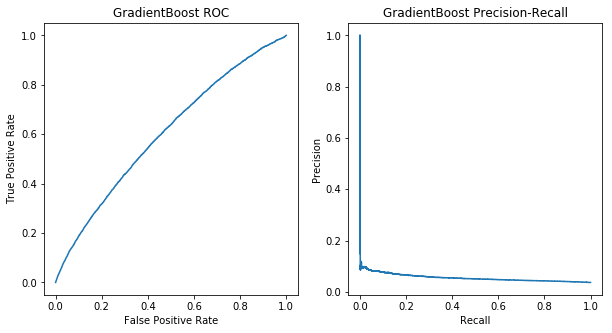

In [49]:
%%time
best = clf.best_estimator_
best.fit(X_res, y_res)

y_pred2 = best.predict(X_test)
y_proba2 = best.predict_proba(X_test)
gini_score = eval_gini(y_test, y_proba2[:, 1])
report2 = classification_report(y_test, y_pred2, digits=4,
                               labels=None, target_names=None)
print(report2)
print('gini = %.4f' % gini_score)
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)

fig, (ax21, ax22) = plt.subplots(1, 2, figsize=(10, 5))
ax21.plot(fpr2, tpr2)
ax21.set_xlabel('False Positive Rate')
ax21.set_ylabel('True Positive Rate')
ax21.set_title('GradientBoost ROC')
ax22.plot(recall2, precision2)
ax22.set_xlabel('Recall')
ax22.set_ylabel('Precision')
ax22.set_title('GradientBoost Precision-Recall')

In [52]:
%%time
xgb = XGBClassifier(n_estimators=200, n_jobs=8)
parameters = {'gamma':[0.1, 1], 'max_depth':[7, 8], 'colsample_bytree':[0.5, .8]}
clf2 = GridSearchCV(xgb, parameters, scoring='f1', verbose=2, n_jobs=1)
clf2.fit(X_res, y_res)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=7 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=7, total=   2.1s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=7 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=7, total=   1.6s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=7 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=7, total=   1.6s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=8 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=8, total=   1.9s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=8 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=8, total=   1.9s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=8 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=8, total=   1.8s
[CV] colsample_bytree=0.5, gamma=1, max_depth=7 ......................
[CV] ....... colsample_bytree=0.5, gamma=1, max_depth=7, total=   1.7s
[CV] colsample_bytree=0.5, gamma=1, max_depth=7 ......................
[CV] ....... colsample_bytree=0.5, gamma=1, max_depth=7, total=   1.6s
[CV] colsample_bytree=0.5, gamma=1, max_depth=7 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.0min finished


CPU times: user 8min 7s, sys: 549 ms, total: 8min 8s
Wall time: 1min 5s


In [53]:
clf2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

             precision    recall  f1-score   support

          0     0.9657    0.9323    0.9487    169358
          1     0.0724    0.1378    0.0949      6496

avg / total     0.9327    0.9029    0.9172    175854

gini = 0.2052
CPU times: user 37.3 s, sys: 75.3 ms, total: 37.4 s
Wall time: 5.2 s


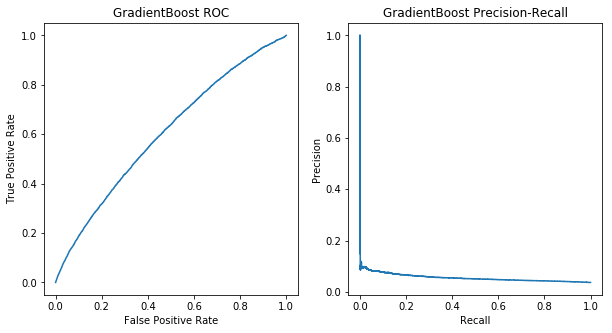

In [54]:
%%time
best2 = clf2.best_estimator_
best2.fit(X_res, y_res)

y_pred2 = best.predict(X_test)
y_proba2 = best.predict_proba(X_test)
gini_score = eval_gini(y_test, y_proba2[:, 1])
report2 = classification_report(y_test, y_pred2, digits=4,
                               labels=None, target_names=None)
print(report2)
print('gini = %.4f' % gini_score)
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)

fig, (ax21, ax22) = plt.subplots(1, 2, figsize=(10, 5))
ax21.plot(fpr2, tpr2)
ax21.set_xlabel('False Positive Rate')
ax21.set_ylabel('True Positive Rate')
ax21.set_title('GradientBoost ROC')
ax22.plot(recall2, precision2)
ax22.set_xlabel('Recall')
ax22.set_ylabel('Precision')
ax22.set_title('GradientBoost Precision-Recall')